# OpenCV DNN Module
---

OpenCV has functionalities for running deep learning inference as well. The best part is supporting the loading of different models from different frameworks using which we can carry out several deep learning functionalities. The feature of supporting models from different frameworks has been a part of OpenCV since version 3.3. Still, many newcomers into the field are not aware of this great feature of OpenCV. Therefore, they tend to miss out on many fun and good learning opportunities.

The OpenCV DNN module only supports deep learning inference on images and videos. It does not support fine-tuning and training. Still, the OpenCV DNN module can act as a perfect starting point for any beginner to get into the field of deep-learning based computer vision and play around.

One of the OpenCV DNN module’s best things is that it is highly optimized for Intel processors. We can get good FPS when running inference on real-time videos for object detection and image segmentation applications. We often get higher FPS with the DNN module when using a model pre-trained using a specific framework. For example, let us take a look at image classification inference speed for different frameworks.

![speed](images/bar-graph-image-classification-speed-comparison-on-cpu-using-different-frameworks.png)

The above results are inference timing for the DenseNet121 model. Surprisingly, OpenCV is a lot faster than TensorFlow’s original implementations while falling behind PyTorch by a small margin. In fact, TensorFlow’s inference time is close to 1 seconds whereas OpenCV takes  less than 200 milliseconds.

The same is true even in the case of object detection:

![speed](images/bar-graph-comparing-speed-of-object-detection-using-different-frameworks-768x427.png)

The above plot shows the results for FPS on video with Tiny YOLOv4 on the original Darknet framework and OpenCV. The benchmark was done on an Intel i7 8th Gen laptop CPU with 2.6Ghz clock speed. We can see that on the same video, the OpenCV’s DNN module is running at 35 FPS whereas Darknet compiled with OpenMP and AVX is running at 15 FPS. And Darknet (without OpenMP or AVX) Tiny YOLOv4 is the slowest, running at only 3 FPS. This is a huge difference considering we are using the original Darknet Tiny YOLOv4 models in both cases.

The above graphs show the actual usefulness and power of the OpenCV DNN module when working with CPUs. Because of its fast inference time, even on CPUs, it can act as an excellent deployment tool on edge devices where computation power is limited. The edge devices based on ARM processors are some of the best examples of this. The following graph is good proof of that.

## Supported Frameworks

The following [link](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) has a reference of all the frameworks and models that are supported. Here, three are showcased: Caffe, tensorflow, and Darknet.

### Caffe

To use a pre-trained Caffe model with OpenCV DNN, we need two things. One is the model.caffemodel file that contains the pre-trained weights. The other one is the model architecture file which has a .prototxt extension. It is like a plain text file with a JSON like structure containing all the neural network layers’ definitions.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

The DenseNet121 model has been trained on the 1000 [ImageNet](https://www.image-net.org/) classes. We will need some way to load these 1000 classes into memory and have easy access to them. The classes are store in the classification_classes_ILSVRC2012.txt file. Then, we will use a pre-trained DenseNet121 model that has been trained using the Caffe deep learning framework.

We will need the model weight files (.caffemodel) and the model configuration file (.prototxt).

We are using a function called readNet() from the OpenCV DNN module, which accepts three input arguments.

- model: This is the path to the pre-trained weights file. In our case, it is the pre-trained Caffe model.
- config: This is the path to the model configuration file and it is the Caffe model’s .prototxt file in this case.
- framework: Finally, we need to provide the framework name that we are loading the models from. For us, it is the Caffe framework.

In [98]:
with open('files/classification_classes_ILSVRC2012.txt', 'r') as f:
    image_net_names = f.read().split('\n')
    
class_names = [name.split(',')[0] for name in image_net_names]

# load the neural network model
model = cv2.dnn.readNet(model='files/DenseNet_121.caffemodel', config='files/DenseNet_121.prototxt', framework='Caffe')

While reading the image, we assume that it is two directories previous to the current directory and inside the input folder. The next few steps are essential. We have a blobFromImage() function which prepares the image in the correct format to be fed into the model. Let us go over all the arguments and learn about them in detail.

- image: This is the input image that we just read above using the imread() function.
- scalefactor: This value scales the image by the provided value. It has a default value of 1 which means that no scaling is performed.
- size: This is the size that the image will be resized to. We have provided the size as 224×224 as most classification models trained on the ImageNet dataset expect this size only.
- mean: The mean argument is pretty important. These are actually the mean values that are subtracted from the image’s RGB color channels. This normalizes the input and makes the final input invariance to different illumination scales.

There is one other thing to note here. All the deep learning models expect input in batches. However, we only have one image here. Nevertheless, the blob output that we get here actually has a shape of [1, 3, 224, 224]. Observe that one extra batch dimension has been added by the blobFromImage() function.

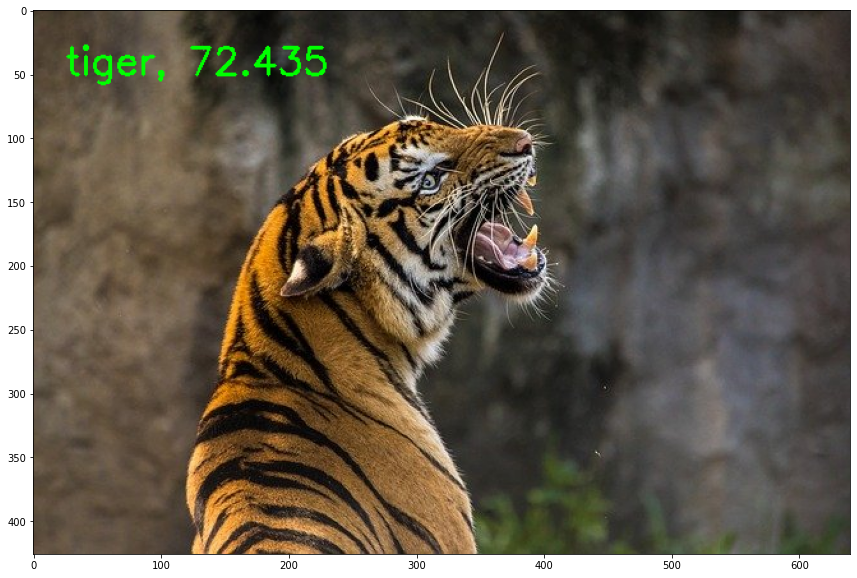

In [111]:
image = cv2.imread('images/tiger.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

blob = blob = cv2.dnn.blobFromImage(image=image, scalefactor=0.01, size=(224, 224), mean=(104, 117, 123))

model.setInput(blob)

outputs = model.forward()

label_id = np.argmax(outputs)
# convert the output scores to softmax probabilities
probs = np.exp(outputs) / np.sum(np.exp(outputs))
# get the final highest probability
final_prob = np.max(probs) * 100.
# map the max confidence to the class label names
out_name = class_names[label_id]
out_text = f"{out_name}, {final_prob:.3f}"

image_copy = np.copy(image)
# put the class name text on top of the image
cv2.putText(image_copy, out_text, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.figure(figsize=(20,10))
plt.imshow(image_copy)

### Object Detection using OpenCV DNN

Using the OpenCV DNN module, we can easily get started with Object Detection in deep learning and computer vision. Like classification, we will load the images, the appropriate models and forward propagate the input through the model. The preprocessing steps for proper visualization in object detection is going to be a bit different.

Just like classification, here also, we will leverage the pre-trained models. These models have been trained on the [MS COCO dataset](https://cocodataset.org/#home), the current benchmark dataset for deep learning based object detection models. MS COCO has almost 80 classes of objects, starting from a person, to a car, to a toothbrush. The dataset contains 80 classes of everyday objects. We will also use a text file to load all the labels present in the MS COCO dataset for object detection. 

We will use [MobileNet SSD](https://arxiv.org/abs/1704.04861) (Single Shot Detector), which has been trained on the MS COCO dataset using the TensorFlow deep learning framework.  SSD models are generally faster when compared to other object detection models. Moreover, the MobileNet backbone also makes them less compute-intensive. So, it is a good model to start learning about object detection with OpenCV DNN.

In [113]:
with open('files/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')

# get a different color array for each of the classes
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

# load the DNN model
mobile_net_model = cv2.dnn.readNet(model='files/frozen_inference_graph.pb',
                        config='files/ssd_mobilenet_v2_coco_2018_03_29.pbtxt.txt', 
                        framework='TensorFlow')

In [112]:
image = cv2.imread('images/pedestrian_bike.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width, _ = image.shape
# create blob from image
blob = cv2.dnn.blobFromImage(image=image, size=(300, 300), mean=(104, 117, 123))
# create blob from image
mobile_net_model.setInput(blob)
# forward pass through the mobile_net_model to carry out the detection
output = mobile_net_model.forward()

For object detection, we are using a bit different argument values in the blobFromImage() function.

We specify the size to be 300×300 as this the input size that SSD models generally expect in almost all frameworks. It is the same for TensorFlow as well. We then set the blob to the MobileNet SSD model and forward propagating it using the forward() function.

The output we have is structured as follows:

[[[[0.00000000e+00 1.00000000e+00 9.72869813e-01 2.06566155e-02 1.11088693e-01 2.40461200e-01 7.53399074e-01]]]]

Here, index position 1 contains the class label, which can be from 1 to 80. 

Index position 2 contains the confidence score. This is not a probability score but rather the model’s confidence for the object belonging to the class that it has detected.

Of the final four values, the first two are x, y bounding box coordinates, and the last is the bounding box’s width and height.

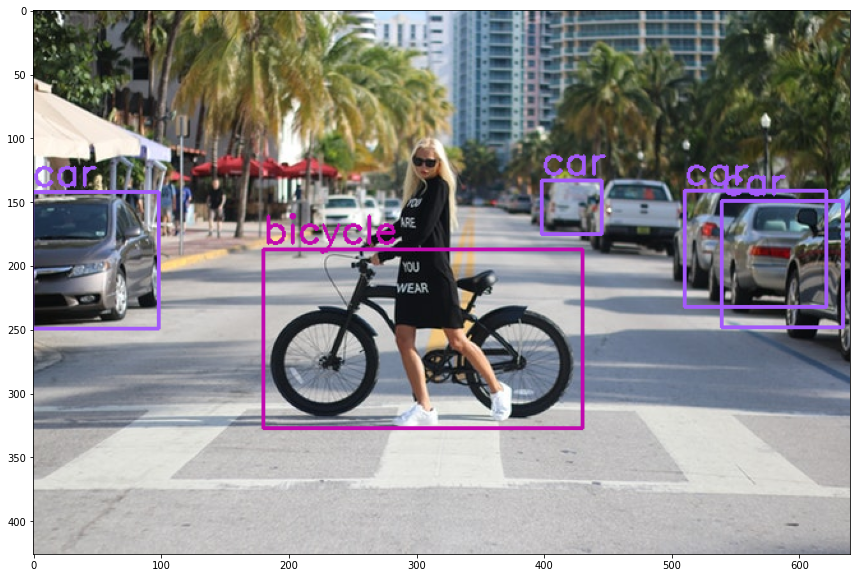

In [114]:
# loop over each of the detection
for detection in output[0, 0, :, :]:
    # extract the confidence of the detection
    confidence = detection[2]
    # draw bounding boxes only if the detection confidence is above...
    # ... a certain threshold, else skip
    if confidence > .6:
        # get the class id
        class_id = detection[1]
        # map the class id to the class
        class_name = class_names[int(class_id)-1]
        color = COLORS[int(class_id)]
        # get the bounding box coordinates
        box_x = detection[3] * image_width
        box_y = detection[4] * image_height
        # get the bounding box width and height
        box_width = detection[5] * image_width
        box_height = detection[6] * image_height
        # draw a rectangle around each detected object
        cv2.rectangle(image, (int(box_x), int(box_y)), (int(box_width), int(box_height)), color, thickness=2)
        # put the FPS text on top of the frame
        cv2.putText(image, class_name, (int(box_x), int(box_y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

plt.figure(figsize=(20,10))
plt.imshow(image)

### [YOLO](https://pjreddie.com/darknet/yolo/)

Prior detection systems repurpose classifiers or localizers to perform detection. They apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections.

We apply a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.

Yolo has several advantages over classifier-based systems. It looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. 



In [85]:
with open('files/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')

# get a different color array for each of the classes
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

# load the DNN model
yolo_model = cv2.dnn.readNetFromDarknet('files/yolov3.cfg', 'files/yolov3.weights')

ln = yolo_model.getLayerNames()
ln = [ln[i-1] for i in yolo_model.getUnconnectedOutLayers()]

print(ln)

['yolo_82', 'yolo_94', 'yolo_106']


In [90]:
image = cv2.imread('images/pedestrian_bike.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_copy = np.copy(image)
image_height, image_width, _ = image.shape

blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), crop=False)
yolo_model.setInput(blob)

layerOutputs = yolo_model.forward(ln)


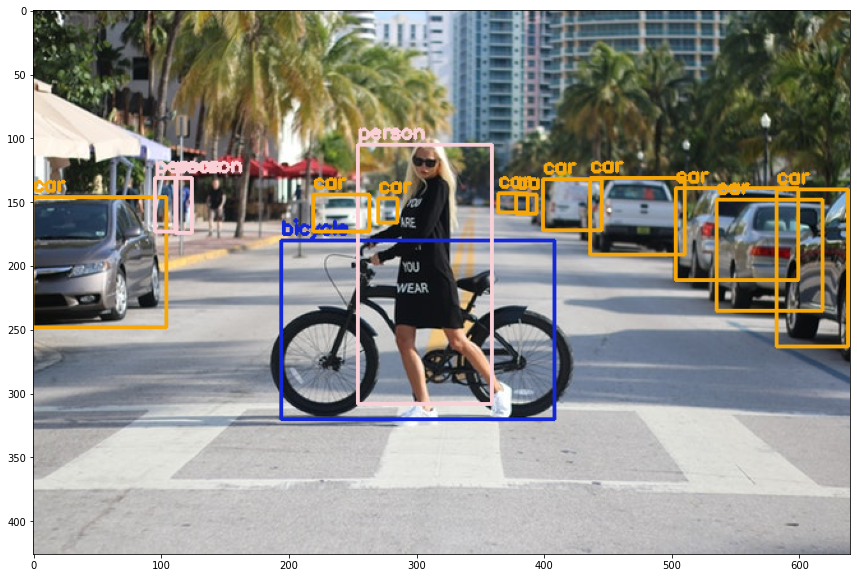

In [91]:
boxes = []
confidences = []
classIDs = []

image_copy = np.copy(image)

# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.2:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([image_width, image_height,image_width, image_height])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image_copy, (x, y), (x + w, y + h), color, 2)
		text = f"{class_names[classIDs[i]]}"
		cv2.putText(image_copy, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(20,10))
plt.imshow(image_copy)